Reading the MNIST Dataset and Converting them into CSV Files.
Reference Script: https://pjreddie.com/projects/mnist-in-csv/
References - http://cs231n.github.io/classification/

In [2]:
import csv
def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

convert("train-images-idx3-ubyte", "train-labels-idx1-ubyte",
        "mnist_train.csv", 60000)
convert("t10k-images-idx3-ubyte", "t10k-labels-idx1-ubyte",
        "mnist_test.csv", 10000)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


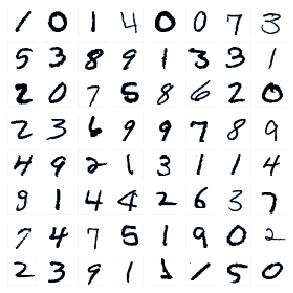

In [8]:
# Read the modules

import numpy as np
import pandas as pd
import seaborn as sb
sb.set_style("dark")
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

%pylab inline

# read in the data

train = pd.read_csv('mnist_train.csv')
#test  = pd.read_csv('mnist_test.csv')
target = train["label"]
train = train.drop("label",1)

# plot some of the numbers

figure(figsize(5,5))
for digit_num in range(0,64):
    subplot(8,8,digit_num+1)
    grid_data = train.iloc[digit_num].as_matrix().reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "bone_r")
    xticks([])
    yticks([])

We would like to know how many components are needed to capture most of the variance in the data. For this we will use the pca.explained_variance_ratio function.

Refernce - https://www.kaggle.com/sflender/digit-recognizer/comparing-random-forest-pca-and-knn

In [9]:
n_components_array=([1,2,3,4,5,10,20,50,100,200,500])
vr = np.zeros(len(n_components_array))
i=0;
for n_components in n_components_array:
    pca = PCA(n_components=n_components)
    pca.fit(train)
    vr[i] = sum(pca.explained_variance_ratio_)
    i=i+1  

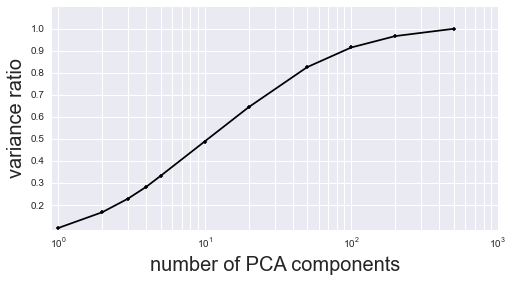

In [10]:
figure(figsize(8,4))
plot(n_components_array,vr,'k.-')
xscale("log")
ylim(9e-2,1.1)
yticks(linspace(0.2,1.0,9))
xlim(0.9)
grid(which="both")
xlabel("number of PCA components",size=20)
ylabel("variance ratio",size=20)

How good is our prediction as a function of number of components? Let's look at this next. We will train a kNN classifier on the PCA output.

# PCA + kNN using the manhattan_distance (l1)

References - http://cs231n.github.io/classification/

In [12]:
clf = KNeighborsClassifier(n_neighbors=1,p=1,n_jobs=-1)
trainX, testX, trainY, testY=train_test_split(train, target, train_size=0.8, random_state=0)
pca = PCA(n_components=100)
pca.fit(trainX)

X_train_pca = pca.transform(trainX)
X_val_pca = pca.transform(testX)

clf.fit(X_train_pca, trainY)
score_array=clf.score(X_val_pca,testY)
score_array_mu, score_array_sigma = mean(score_array), std(score_array)
print score_array_mu, score_array_sigma


0.966428571429 0.0


## PCA + kNN using the euclidean_distance (l2)

In [13]:
clf = KNeighborsClassifier(n_neighbors=1,p=2,n_jobs=-1)
trainX, testX, trainY, testY=train_test_split(train, target, train_size=0.8, random_state=0)

pca = PCA(n_components=100)
pca.fit(trainX)
X_train_pca = pca.transform(trainX)
X_val_pca = pca.transform(testX)

clf.fit(X_train_pca, trainY)
score_array=clf.score(X_val_pca,testY)

score_array_mu, score_array_sigma = mean(score_array), std(score_array)
print score_array_mu, score_array_sigma

0.974285714286 0.0


## Plot the Confusion Matrix for the 1-Nearest Neighbour Classification Algorithm
References - http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [14]:
from sklearn.metrics import confusion_matrix
results_predicted=clf.predict(X_val_pca)
cnf_matrix=confusion_matrix(testY, results_predicted, labels=[0,1,2,3,4,5,6,7,8,9])

Confusion matrix, without normalization
[[804   0   1   2   1   1   3   0   0   1]
 [  0 951   3   1   1   0   1   2   2   0]
 [  5   1 839   2   0   0   1   7   5   0]
 [  0   0   2 833   0  15   1   5   2   5]
 [  1   4   0   0 797   0   2   2   0  21]
 [  2   1   1   8   0 735   7   0   1   1]
 [  0   1   0   0   1   2 837   0   0   0]
 [  0   5   5   0   3   0   0 879   0   7]
 [  0   3   1  10   1   8   4   0 734   7]
 [  3   1   1   2  12   2   1  14   1 775]]


/Users/karanuppal/anaconda/envs/gl-env/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


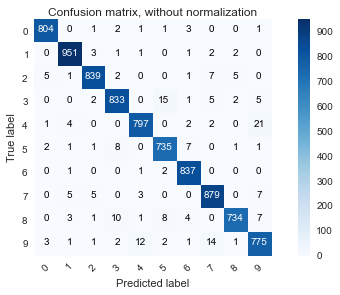

In [15]:
# Plot non-normalized confusion matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
import matplotlib.pyplot as plt
classes = [0,1,2,3,4,5,6,7,8,9]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix, without normalization')

plt.show()

## PCA + SVM

0.982857142857 0.0
Confusion matrix, without normalization
[[804   0   2   0   1   1   3   0   2   0]
 [  0 952   1   3   0   0   1   2   2   0]
 [  2   1 848   0   1   0   2   3   3   0]
 [  0   1   2 838   1   8   0   2   8   3]
 [  1   1   1   0 812   0   3   1   2   6]
 [  0   0   0   3   0 746   4   0   3   0]
 [  0   0   1   0   1   4 834   0   1   0]
 [  1   3   5   1   1   1   0 883   0   4]
 [  0   1   1   3   0   2   1   0 759   1]
 [  5   0   1   4   9   3   1   6   3 780]]


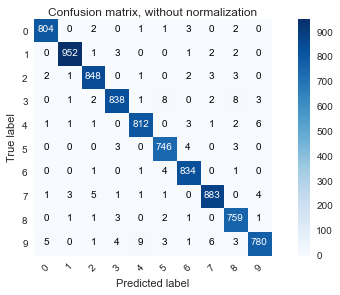

In [16]:
from sklearn import svm
train = pd.read_csv('mnist_train.csv')
train_image = train.ix[:,1:]
train_label = train.ix[:,0]

train_image = train_image.values / 255.0
train_label = train_label.values

clf = svm.SVC(C=10)
trainX, testX, trainY, testY=train_test_split(train_image,train_label, train_size = 0.8,random_state = 0)
pca = PCA(n_components=0.75)
pca.fit(trainX)
X_train_pca = pca.transform(trainX)
X_val_pca = pca.transform(testX)

clf.fit(X_train_pca, trainY)
score_array=clf.score(X_val_pca,testY)

score_array_mu, score_array_sigma = mean(score_array), std(score_array)
print score_array_mu, score_array_sigma

from sklearn.metrics import confusion_matrix
results_predicted=clf.predict(X_val_pca)
cnf_matrix=confusion_matrix(testY, results_predicted, labels=[0,1,2,3,4,5,6,7,8,9])

import matplotlib.pyplot as plt
classes = [0,1,2,3,4,5,6,7,8,9]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix, without normalization')

plt.show()

In [5]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import time

train = pd.read_csv('mnist_train.csv')

train_image = train.ix[:,1:]
train_label = train.ix[:,0]

train_image = train_image.values / 255.0
train_label = train_label.values

print('the shape of train_image: {}, train_label: {}'.format(train_image.shape, train_label.shape))

X_train, X_val, y_train, y_val = train_test_split(train_image,train_label, train_size = 0.8,random_state = 0)
def n_component_analysis(n, X_train, y_train, X_val, y_val):
    start = time.time()
    pca = PCA(n_components=n)
    print("PCA begin with n_components: {}".format(n));
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_val_pca = pca.transform(X_val)
    print('SVC begin')
    clf1 = svm.SVC()
    clf1.fit(X_train_pca, y_train)
    accuracy = clf1.score(X_val_pca, y_val)
    end = time.time()
    print("accuracy: {}, time elaps:{}".format(accuracy, int(end-start)))
    return accuracy

n_s = np.linspace(0.70, 0.85, num=15)
accuracy = []
for n in n_s:
    tmp = n_component_analysis(n, X_train, y_train, X_val, y_val)
    accuracy.append(tmp)

the shape of train_image: (42000, 784), train_label: (42000,)
PCA begin with n_components: 0.7
SVC begin
accuracy: 0.97869047619, time elaps:19
PCA begin with n_components: 0.710714285714
SVC begin
accuracy: 0.979166666667, time elaps:21
PCA begin with n_components: 0.721428571429
SVC begin
accuracy: 0.979404761905, time elaps:20
PCA begin with n_components: 0.732142857143
SVC begin
accuracy: 0.979404761905, time elaps:23
PCA begin with n_components: 0.742857142857
SVC begin
accuracy: 0.980119047619, time elaps:23
PCA begin with n_components: 0.753571428571
SVC begin
accuracy: 0.979761904762, time elaps:23
PCA begin with n_components: 0.764285714286
SVC begin
accuracy: 0.979880952381, time elaps:27
PCA begin with n_components: 0.775
SVC begin
accuracy: 0.979166666667, time elaps:25
PCA begin with n_components: 0.785714285714
SVC begin
accuracy: 0.97880952381, time elaps:29
PCA begin with n_components: 0.796428571429
SVC begin
accuracy: 0.979047619048, time elaps:24
PCA begin with n_com

In [ ]:
from sklearn.metrics import confusion_matrix
results_predicted=clf.predict(X_val_pca)
cnf_matrix=confusion_matrix(testY, results_predicted, labels=[0,1,2,3,4,5,6,7,8,9])